In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM,Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [239]:
data=pd.read_csv("Amazon.csv",parse_dates=["Date"])

In [240]:
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
5,1997-05-22,1.437500,1.447917,1.312500,1.395833,1.395833,11776800
6,1997-05-23,1.406250,1.520833,1.333333,1.500000,1.500000,15937200
7,1997-05-27,1.510417,1.645833,1.458333,1.583333,1.583333,8697600
8,1997-05-28,1.625000,1.635417,1.531250,1.531250,1.531250,4574400
9,1997-05-29,1.541667,1.541667,1.479167,1.505208,1.505208,3472800


In [241]:
data.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
6150,2021-10-21,3414.25000,3440.280029,3403.000000,3435.010010,3435.010010,1881400
6151,2021-10-22,3421.00000,3429.840088,3331.300049,3335.550049,3335.550049,3133800
6152,2021-10-25,3335.00000,3347.800049,3297.699951,3320.370117,3320.370117,2226000
6153,2021-10-26,3349.51001,3416.120117,3343.979980,3376.070068,3376.070068,2693700
6154,2021-10-27,3388.00000,3412.000000,3371.453369,3396.189941,3396.189941,1080291


In [242]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6155 entries, 0 to 6154
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6155 non-null   datetime64[ns]
 1   Open       6155 non-null   float64       
 2   High       6155 non-null   float64       
 3   Low        6155 non-null   float64       
 4   Close      6155 non-null   float64       
 5   Adj Close  6155 non-null   float64       
 6   Volume     6155 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 336.7 KB


In [243]:
data.shape

(6155, 7)

In [244]:
data.duplicated().sum()

np.int64(0)

In [245]:
data.isnull().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [246]:
cols=["Open","Close","High","Low","Adj Close"]
for col in cols:
    data[col]=data[col].astype(float)


In [247]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6155 entries, 0 to 6154
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6155 non-null   datetime64[ns]
 1   Open       6155 non-null   float64       
 2   High       6155 non-null   float64       
 3   Low        6155 non-null   float64       
 4   Close      6155 non-null   float64       
 5   Adj Close  6155 non-null   float64       
 6   Volume     6155 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 336.7 KB


In [248]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [249]:
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

VISUALIZATION AND TREND ANALYSIS

<Axes: xlabel='Date'>

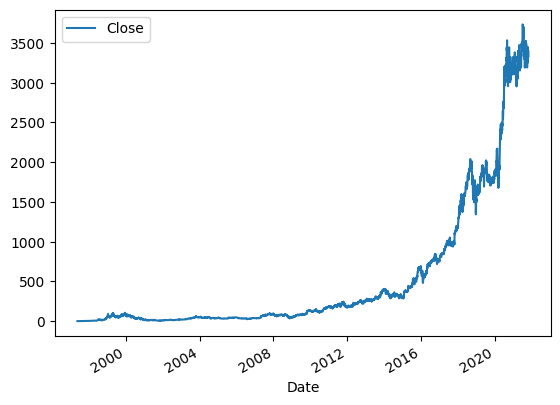

In [250]:
data.set_index("Date",inplace=True)
data.plot.line(y="Close",use_index=True)


In [251]:
data.reset_index(inplace=True)

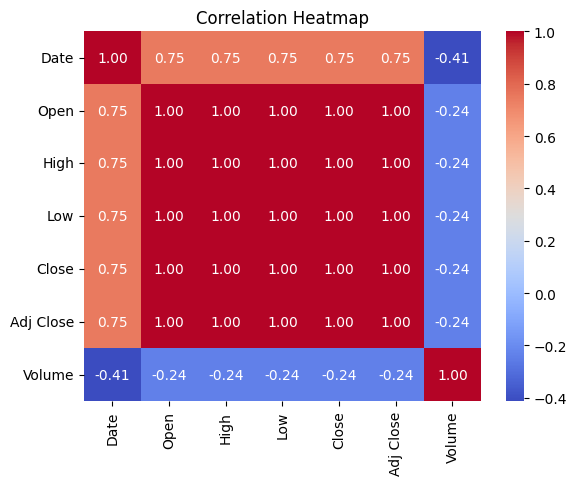

In [252]:
correlations=data.corr()
plt.Figure(figsize=(10,8))
sns.heatmap(correlations,annot=True,fmt=".2f",cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Feature Engineering

In [253]:
#Return features
data["daily_return"]=data["Close"].pct_change()
data["log_return"]=np.log(data["Close"]/ data["Close"].shift(1))
data["trading range"]=(data["High"] - data["Low"])/ data["Low"]
data['price movement']=(data["Close"] - data["Open"])/ data["Open"]

In [254]:
#Price Ratios
data["close_open_ratio"]=data["Close"]/data["Open"]
data["high_low_ratio"]=data["High"]/data["Low"]

In [255]:
#moving averages
data["simple_avg_5"]=data["Close"].rolling(window=5).mean()
data["simple_avg_10"]=data["Close"].rolling(window=10).mean()
data["simple_std_10"]=data["Close"].rolling(window=10).std()
data["exponential_avg_10"]=data["Close"].ewm(span=10,adjust=False).mean()
data["rolling_mean_volume5"]=data["Volume"].rolling(window=5).mean()
data["rolling_mean_volume10"]=data["Volume"].rolling(window=10).mean()


In [256]:
#Volatility features capture market instability and are useful for detecting volatility compression or expansion.
data["volatility_5"]=data["daily_return"].rolling(window=5).std()
data["volatility_10"]=data["daily_return"].rolling(window=10).std()

In [257]:
#lag features
#Lag features of price and volume  give the model memory of recent past values
data["close_lag1"]=data["Close"].shift(1)
data["close_lag5"]=data["Close"].shift(5)
data["open_lag1"]=data["Open"].shift(1)
data["open_lag5"]=data["Open"].shift(5)
data["daily_return_lag1"]=data["daily_return"].shift(1)

In [258]:
#Time features - captures seasonality and patterns related to time
data["day_of_week"]=data["Date"].dt.dayofweek
data["month"] =data["Date"].dt.month

In [259]:
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,daily_return,log_return,trading range,...,rolling_mean_volume10,volatility_5,volatility_10,close_lag1,close_lag5,open_lag1,open_lag5,daily_return_lag1,day_of_week,month
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,NaN,NaN,0.297298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,5
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,-0.117021,-0.124454,0.158537,...,NaN,NaN,NaN,1.958333,NaN,2.437500,NaN,NaN,4,5
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,-0.012049,-0.012122,0.089743,...,NaN,NaN,NaN,1.729167,NaN,1.968750,NaN,-0.117021,0,5
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,-0.042683,-0.043620,0.070063,...,NaN,NaN,NaN,1.708333,NaN,1.760417,NaN,-0.012049,1,5
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,-0.127389,-0.136265,0.196969,...,NaN,NaN,NaN,1.635417,NaN,1.729167,NaN,-0.042683,2,5
5,1997-05-22,1.437500,1.447917,1.312500,1.395833,1.395833,11776800,-0.021898,-0.022141,0.103175,...,NaN,0.054211,NaN,1.427083,1.958333,1.635417,2.437500,-0.127389,3,5
6,1997-05-23,1.406250,1.520833,1.333333,1.500000,1.500000,15937200,0.074627,0.071974,0.140625,...,NaN,0.072276,NaN,1.395833,1.729167,1.437500,1.968750,-0.021898,4,5
7,1997-05-27,1.510417,1.645833,1.458333,1.583333,1.583333,8697600,0.055555,0.054067,0.128571,...,NaN,0.081273,NaN,1.500000,1.708333,1.406250,1.760417,0.074627,1,5
8,1997-05-28,1.625000,1.635417,1.531250,1.531250,1.531250,4574400,-0.032895,-0.033448,0.068027,...,NaN,0.080474,NaN,1.583333,1.635417,1.510417,1.729167,0.055555,2,5
9,1997-05-29,1.541667,1.541667,1.479167,1.505208,1.505208,3472800,-0.017007,-0.017153,0.042254,...,16174200.0,0.049560,NaN,1.531250,1.427083,1.625000,1.635417,-0.032895,3,5


In [260]:
data[data.isnull().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume,daily_return,log_return,trading range,...,rolling_mean_volume10,volatility_5,volatility_10,close_lag1,close_lag5,open_lag1,open_lag5,daily_return_lag1,day_of_week,month
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,NaN,NaN,0.297298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,5
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,-0.117021,-0.124454,0.158537,...,NaN,NaN,NaN,1.958333,NaN,2.437500,NaN,NaN,4,5
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,-0.012049,-0.012122,0.089743,...,NaN,NaN,NaN,1.729167,NaN,1.968750,NaN,-0.117021,0,5
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,-0.042683,-0.043620,0.070063,...,NaN,NaN,NaN,1.708333,NaN,1.760417,NaN,-0.012049,1,5
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,-0.127389,-0.136265,0.196969,...,NaN,NaN,NaN,1.635417,NaN,1.729167,NaN,-0.042683,2,5
5,1997-05-22,1.437500,1.447917,1.312500,1.395833,1.395833,11776800,-0.021898,-0.022141,0.103175,...,NaN,0.054211,NaN,1.427083,1.958333,1.635417,2.437500,-0.127389,3,5
6,1997-05-23,1.406250,1.520833,1.333333,1.500000,1.500000,15937200,0.074627,0.071974,0.140625,...,NaN,0.072276,NaN,1.395833,1.729167,1.437500,1.968750,-0.021898,4,5
7,1997-05-27,1.510417,1.645833,1.458333,1.583333,1.583333,8697600,0.055555,0.054067,0.128571,...,NaN,0.081273,NaN,1.500000,1.708333,1.406250,1.760417,0.074627,1,5
8,1997-05-28,1.625000,1.635417,1.531250,1.531250,1.531250,4574400,-0.032895,-0.033448,0.068027,...,NaN,0.080474,NaN,1.583333,1.635417,1.510417,1.729167,0.055555,2,5
9,1997-05-29,1.541667,1.541667,1.479167,1.505208,1.505208,3472800,-0.017007,-0.017153,0.042254,...,16174200.0,0.049560,NaN,1.531250,1.427083,1.625000,1.635417,-0.032895,3,5


In [261]:
data=data.dropna()

In [262]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,daily_return,log_return,trading range,...,rolling_mean_volume10,volatility_5,volatility_10,close_lag1,close_lag5,open_lag1,open_lag5,daily_return_lag1,day_of_week,month
10,1997-05-30,1.500000,1.510417,1.479167,1.500000,1.500000,2594400,-0.003460,-0.003466,0.021127,...,9218040.0,0.047060,0.063633,1.505208,1.395833,1.541667,1.437500,-0.017007,4,5
11,1997-06-02,1.510417,1.531250,1.500000,1.510417,1.510417,591600,0.006945,0.006921,0.020833,...,7807200.0,0.033545,0.055091,1.500000,1.500000,1.500000,1.406250,-0.003460,0,6
12,1997-06-03,1.531250,1.531250,1.479167,1.479167,1.479167,1183200,-0.020690,-0.020907,0.035211,...,7314840.0,0.015483,0.055159,1.510417,1.583333,1.510417,1.510417,0.006945,1,6
13,1997-06-04,1.479167,1.489583,1.395833,1.416667,1.416667,3080400,-0.042254,-0.043172,0.067164,...,7076160.0,0.018665,0.055134,1.479167,1.531250,1.531250,1.625000,-0.020690,2,6
14,1997-06-05,1.416667,1.541667,1.375000,1.541667,1.541667,5672400,0.088235,0.084557,0.121212,...,5758080.0,0.049733,0.046911,1.416667,1.505208,1.479167,1.541667,-0.042254,3,6


In [275]:

x= data.drop(["Date","Adj Close","Open","High","Low"], axis=1, inplace=False) 
y=data["Close"]  


In [276]:
scaler=MinMaxScaler(feature_range=(0, 1))
x_scaled=scaler.fit_transform(x)
y_scaled=scaler.fit_transform(y.values.reshape(-1,1))

In [277]:
y_scaled.shape

(6145, 1)

In [278]:
#reshape the data for LSTM
timesteps=60
def create_sequence(x, y, timesteps):
    x = np.array(x)
    y = np.array(y)
    x_seq, y_seq = [], []
    for i in range(len(x) - timesteps):
        x_seq.append(x[i:i + timesteps])
        y_seq.append(y[i + timesteps])   
    return np.array(x_seq), np.array(y_seq)
x_seq,y_seq=create_sequence(x_scaled,y_scaled,timesteps)

In [279]:
train_size=int(len(x_seq)*0.7)
val_size=int(len(x_seq)*0.15)
x_train,y_train=x_seq[:train_size],y_seq[:train_size]
x_val,y_val=x_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
x_test,y_test=x_seq[train_size + val_size :],y_seq[train_size + val_size :]

In [280]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((4259, 60, 23), (4259, 1), (914, 60, 23), (914, 1), (912, 60, 23), (912, 1))

In [304]:
model1_lstm = Sequential()
model1_lstm.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model1_lstm.add(Dropout(0.2))
model1_lstm.add(LSTM(64))
model1_lstm.add(Dropout(0.2))
model1_lstm.add(Dense(128, activation='relu'))
model1_lstm.add(Dropout(0.2))
model1_lstm.add(Dense(64, activation='relu'))
model1_lstm.add(Dense(1))
model1_lstm.compile(optimizer=Adam(learning_rate=0.00001), loss='mse')

In [305]:
#train the model
early_stop=EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
model1_lstm.fit(x_train, y_train, epochs=100,verbose=1, batch_size=32,validation_data=(x_val,y_val),shuffle=False,callbacks=[early_stop])
y_pred_lstm =model1_lstm.predict(x_test)


Epoch 1/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0016 - val_loss: 0.0195
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0017 - val_loss: 0.0206
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0012 - val_loss: 0.0202
Epoch 4/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0010 - val_loss: 0.0195
Epoch 5/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - loss: 8.6127e-04 - val_loss: 0.0187
Epoch 6/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 7.5069e-04 - val_loss: 0.0177
Epoch 7/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 6.8901e-04 - val_loss: 0.0165
Epoch 8/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - loss: 6.3728e-04 - val_loss: 0.0155
Epoch 9/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - loss: 5.7015e-04 - val_loss: 0.0140
Epoch 10/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - loss: 5.3717e-04 - val_loss: 0.0126
Epoch 11/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 4.8281e-04 - val_loss

In [306]:
y_pred_lstm_rescaled = scaler.inverse_transform(y_pred_lstm)
y_test_rescaled = scaler.inverse_transform(y_test)

In [307]:
y_pred_lstm_rescaled.shape, y_test_rescaled.shape

((914, 1), (914, 1))

In [308]:
y_pred_lstm_rescaled[:5].ravel(),y_test_rescaled[:5].ravel()

(array([1228.7633, 1235.958 , 1240.4388, 1241.4558, 1247.8082],
       dtype=float32),
 array([1591.      , 1582.319946, 1571.680054, 1544.930054, 1586.51001 ]))

In [309]:
r2_score(y_test_rescaled,y_pred_lstm_rescaled)

-0.35595516619579315